In [1]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/twin-polyak


In [2]:
%load_ext autoreload
%autoreload 2

import os
import datetime
import time
from collections import defaultdict
import pickle

import numpy as np
import numba

import matplotlib.pyplot as plt

from experiments import utils
from experiments.loss_functions import LogisticRegressionLoss, BaseOracle
from experiments.methods import *

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import scipy
import svmlight_loader

from dotenv import load_dotenv
load_dotenv()

True

In [3]:
np.random.seed(0)
n = 2000
d = 50
dataset_name = "synthetic-interpolation"
data, target = utils.make_synthetic_binary_classification(n, d)
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=0)

L = (0.25 / train_data.shape[0]) * np.linalg.norm(train_data.T.dot(train_data), ord=2)
dataset = train_data, train_target, test_data, test_target

batch_size = train_data.shape[0]

print(f"{L=}")
print(f"{1/L=}")

dataset = train_data, train_target, test_data, test_target

L=0.3376891311044958
1/L=2.961303482671334


In [105]:
np.random.seed(0)
n = 2000
d = 100
dataset_name = "synthetic-interpolation"

data, target = make_classification(n_samples=n, n_features=d, n_redundant=0, n_clusters_per_class=1, class_sep=3.0, random_state=0)
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=0)

train_target = utils.map_classes_to(train_target, [-1.0, 1.0])
test_target = utils.map_classes_to(test_target, [-1.0, 1.0])

L = (0.25 / train_data.shape[0]) * np.linalg.norm(train_data.T @ train_data, ord=2)

batch_size = train_data.shape[0]

print(f"{L=}")
print(f"{1/L=}")
print(f"{np.unique(train_target)=}")

dataset = train_data, train_target, test_data, test_target

L=2.389895931489896
1/L=0.4184282615923721
np.unique(train_target)=array([-1.,  1.])


In [113]:
np.random.seed(0)
n = 2000
d = 100
dataset_name = "synthetic-no-interpolation"

data, target = make_classification(n_samples=n, n_features=d, n_redundant=0, n_clusters_per_class=2, class_sep=0.1, random_state=0)
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=0)

train_target = utils.map_classes_to(train_target, [-1.0, 1.0])
test_target = utils.map_classes_to(test_target, [-1.0, 1.0])


L = (0.25 / train_data.shape[0]) * np.linalg.norm(train_data.T.dot(train_data), ord=2)

batch_size = train_data.shape[0]

print(f"{L=}")
print(f"{1/L=}")
print(f"{np.unique(train_target)=}")

dataset = train_data, train_target, test_data, test_target

L=0.3813798712150801
1/L=2.622057626727887
np.unique(train_target)=array([-1.,  1.])


In [120]:
dataset_name = "a1a"
train_data, train_target, test_data, test_target = utils.get_libsvm(dataset_name, test_split=0.0)

# if scipy.sparse.issparse(train_data):
#     scaler = StandardScaler(with_mean=False)
# else:
#     scaler = StandardScaler()
# scaler.fit(train_data)  
# train_data = scaler.transform(train_data)
# test_data = scaler.transform(test_data)

L = (0.25 / train_data.shape[0]) * scipy.sparse.linalg.norm(train_data.T @ train_data, ord=2)
train_target = utils.map_classes_to(train_target, [-1.0, 1.0])
test_target = utils.map_classes_to(test_target, [-1.0, 1.0])

batch_size = train_data.shape[0]

print(f"{1/L=}")
print(f"{batch_size=}")
print(f"{train_data.shape=}, {test_data.shape=}")
print(f"{np.unique(train_target)=}, {np.unique(test_target)=}")

dataset = train_data, train_target, test_data, test_target


1/L=0.63809795026046
batch_size=1605
train_data.shape=(1605, 123), test_data.shape=(30956, 123)
np.unique(train_target)=array([-1.,  1.]), np.unique(test_target)=array([-1.,  1.])


In [121]:
def plotter(histories, labels, colors=None, linestyles=None, 
            linewidths=None, markers=None, f_star=None, suptitle=None, 
            x_labels=None, y_labels=None,
            threshold=1e-10, xlims=None, tight_layout=True, filename=None):
    
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
        
    if colors is None:
        colors = list(plt.cm.colors.XKCD_COLORS.keys())
        np.random.shuffle(colors)
        colors = list(plt.cm.colors.BASE_COLORS) + colors
        
    if linestyles is None:
        linestyles = ["-" for x in histories]
    
    if linewidths is None:
        linewidths = [1.5 for x in histories]
        
    if markers is None:
        markers = [" " for x in histories]
        
    # if f_star is None:
    #     f_star = np.min([x["loss"] for x in histories])
    # else:
    #     f_star = np.min([f_star for x in histories])
    
    for history, label, c, ls, lw, m in zip(histories, labels, colors, linestyles, linewidths, markers):
        # f_suboptim = (history["loss"] - f_star) / (history["loss"][0] - f_star)
        # f_suboptim[f_suboptim < threshold] = 0.0
        try:
            markevery = [x + np.random.randint(0, 1) for x in range(0, len(history["test/loss"]), len(history["test/loss"]) // 10)]
        except:
            markevery = []
        
        ax[0].semilogy(history["test/loss"], linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m)
        ax[1].semilogy(history["test/grad_norm_sq"], linestyle=ls, linewidth=lw, color=c, label=label, markevery=markevery, marker=m)
        ax[2].plot(history["test/acc"], linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m)
        ax[3].plot(history["lr"], linestyle=ls, linewidth=lw, color=c)


    if f_star == 0.0:
        ax[0].set_ylabel(r"$f(x_k)$")
        ax[1].set_ylabel(r"$\| f(x_k) \|^2$")
    else:
        ax[0].set_ylabel(r"$(f(x_k) - f^*)/(f(x_0) - f^*)$")
        ax[1].set_ylabel(r"$\| f(x_k) \|^2$")
        
    ax[2].set_ylabel("Accuracy")
    ax[3].set_ylabel("step-size")
    
    ax[0].set_xlabel("Epochs")
    ax[1].set_xlabel("Epochs")
    ax[2].set_xlabel("Epochs")
    ax[3].set_xlabel("Epochs")


    if xlims is not None:
        ax[1].set_xlim(right=xlims[1])

    fig.legend()
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    ax[3].grid()

    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        fig.savefig(filename)
    else:
        fig.show()    

In [122]:
def train_loop(dataset: list[np.ndarray], 
               batch_size: int, 
               n_epochs: int,
               optimizer: BaseOptimizer,
               seed: int = 0,
               **optimizer_kwargs) -> dict: 

    np.random.seed(seed)

    train_data, train_target, test_data, test_target = dataset
    
    # parameters
    params = np.zeros(train_data.shape[1])
    optim = optimizer(params, **optimizer_kwargs)

    # oracle 
    loss_function = LogisticRegressionLoss()
    
    # logging 
    history = defaultdict(list)

    indices = np.arange(train_data.shape[0])
    
    for epoch in range(n_epochs):
        
        # Evaluation 
        loss, grad, acc = loss_function.func_grad_acc(params, test_data, test_target)
        g_norm_sq = np.linalg.norm(grad)**2
        history["test/loss"].append(loss)
        history["test/acc"].append(acc)
        history["test/grad_norm_sq"].append(g_norm_sq)
        
        # Training 
        np.random.shuffle(indices)

        for idx in range(train_data.shape[0]//batch_size):
            batch_indices = indices[idx*batch_size:(idx+1)*batch_size]
            batch_data = train_data[batch_indices]
            batch_target = train_target[batch_indices] 
        
            train_loss, train_grad, _ = loss_function.func_grad_acc(params, batch_data, batch_target)
            
            optim.step(loss=train_loss, grad=train_grad)
            history["lr"].append(optim.lr)

    # Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params, test_data, test_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["test/loss"].append(loss)
    history["test/acc"].append(acc)
    history["test/grad_norm_sq"].append(g_norm_sq)
    
    # print(f"Test Loss: {test_loss} | Test Acc: {test_acc} | Test GradNorm**2: {test_g_norm}")
    
    return history

In [123]:
class SPS(BaseOptimizer):
    
    def __init__(self, params: np.ndarray, 
                 c: float = 0.5, 
                 eps: float = 1e-8,
                 eta_max: float = np.inf):
        
        self.params = params
        self.lr = 1.0
        self.eps = eps
        self.c = c
        self.eta_max = eta_max
        
        self.defaults = dict(
            lr=1.0,
            c=c,
            eps=eps,
            )
        
    def step(self, loss, grad):
        
        self.lr = loss / ( self.c * np.linalg.norm(grad)**2 + self.eps )
        self.lr = np.minimum(self.eta_max, self.lr)
        self.params -= self.lr * grad
            
        return loss, grad


class SPS_MA(BaseOptimizer):
    
    def __init__(self, params: np.ndarray, 
                 c: float = 0.5, 
                 eps: float = 1e-8,
                 eta_max: float = 0.0,
                 betas: tuple[float, float] = (0.9, 0.9)):
        
        self.params = params
        self.lr = 1.0
        self.eps = eps
        self.c = c
        self.betas = betas
        self.eta_max = eta_max
        
        self.defaults = dict(
            lr=1.0,
            c=c,
            eps=eps,
            )
        
        self._step_t = 0
        
        self.sum_f = 0.0
        self.sum_g = np.zeros_like(self.params)
        
    def step(self, loss, grad):
        
        self._step_t += 1
        
        self.sum_f = self.betas[0] * self.sum_f + (1 - self.betas[0]) * loss
        self.sum_g = self.betas[1] * self.sum_g + (1 - self.betas[1]) * grad
        # sum_hat = self.sum_g / (1 - self.beta**self._step_t)

        self.lr = self.sum_f / ( self.c * np.linalg.norm(self.sum_g)**2 + self.eps )        
        self.params -= self.lr * grad
            
        return loss, grad

In [124]:
def twin_model(dataset: list[np.ndarray], 
               batch_size: int, 
               n_epochs: int,
               seed: int = 0
               ) -> dict: 
    
    np.random.seed(seed)

    train_data, train_target, test_data, test_target = dataset

    # parameters
    params_x = np.zeros(train_data.shape[1])
    params_y = np.zeros(train_data.shape[1]) + 5.0
    
    print(params_x)
    print(params_y)

    # oracle 
    loss_function = LogisticRegressionLoss()
    
    # logging 
    history = defaultdict(list)

    indices = np.arange(train_data.shape[0])
    
    # Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params_x, test_data, test_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["test/loss"].append(loss)
    history["test/acc"].append(acc)
    history["test/grad_norm_sq"].append(g_norm_sq)
    
    for epoch in range(n_epochs):
    
        # Training 
        if batch_size != train_data.shape[0]:
            np.random.shuffle(indices)

        for idx in range(train_data.shape[0]//batch_size):
            batch_indices = indices[idx*batch_size:(idx+1)*batch_size]
            batch_data = train_data[batch_indices]
            batch_target = train_target[batch_indices] 
            
            
            train_loss_x, train_grad_x, _ = loss_function.func_grad_acc(params_x, batch_data, batch_target)
            train_loss_y, train_grad_y, _  = loss_function.func_grad_acc(params_y, batch_data, batch_target)
            
            print(f"Before: {train_loss_x=}, {train_loss_y=}")
            
            if train_loss_x < train_loss_y:
                # print(f"{train_loss_x=} < {train_loss_y=}")
                params_x, params_y = params_y, params_x
                train_loss_x, train_loss_y = train_loss_y, train_loss_x
                train_grad_x, train_grad_y = train_grad_y, train_grad_x
                
            print(f"After: {train_loss_x=}, {train_loss_y=} \n")


            # Optimization step
            lr = np.minimum(( (train_loss_x - train_loss_y) / (0.5 * np.linalg.norm(train_grad_x)**2 + 1e-8) ), np.inf)
            params_x -= lr * train_grad_x
            
            # print(f"{train_loss_x=}, {np.linalg.norm(train_grad_x)=}")
            # print(f"{train_loss_y=}, {np.linalg.norm(train_grad_y)=}")
            print(f"{lr=}\n")

            
            history["lr"].append(lr)
        
        # Evaluation 
        loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, test_data, test_target)
        loss_y, grad_y, acc_y = loss_function.func_grad_acc(params_y, test_data, test_target)
        
        if loss_x < loss_y:
            g_norm_sq = np.linalg.norm(grad_x)**2
            history["test/loss"].append(loss_x)
            history["test/acc"].append(acc_x)
            history["test/grad_norm_sq"].append(g_norm_sq)
        else:
            g_norm_sq = np.linalg.norm(grad_y)**2
            history["test/loss"].append(loss_y)
            history["test/acc"].append(acc_y)
            history["test/grad_norm_sq"].append(g_norm_sq)

    
    return history

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5.]
Before: train_loss_x=0.6931471805599452, train_loss_y=52.15264797507788
After: train_loss_x=52.15264797507788, train_loss_y=0.6931471805599452 

lr=29.129657744120532

Before: train_loss_x=15.110728530201643, train_loss_y=0.6931471805599452
After: 

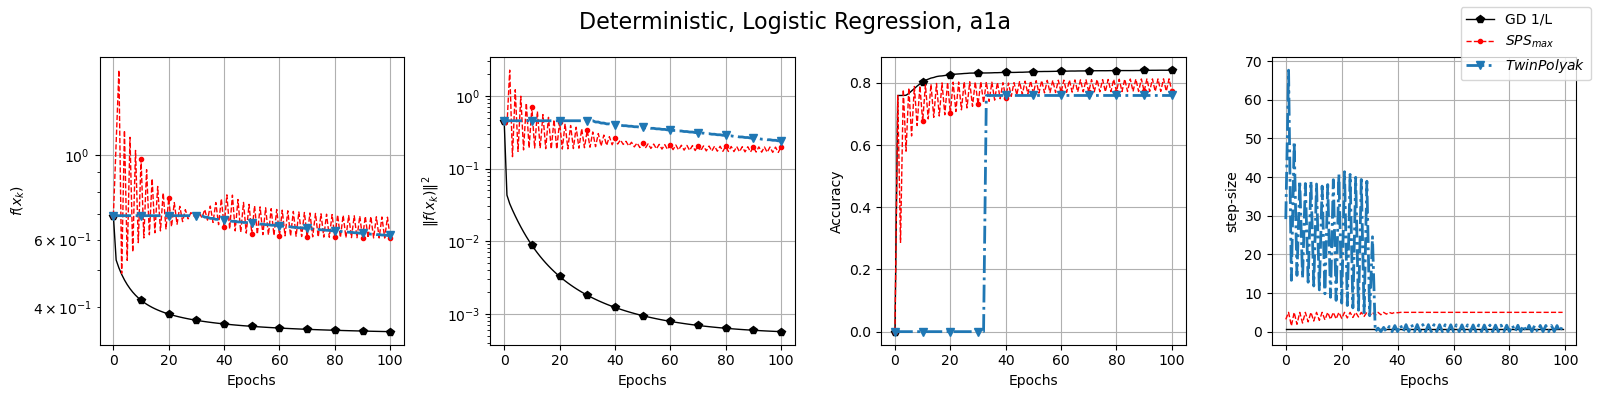

In [125]:
n_epochs = 100
seed = 0

histories = []
labels = []

hist_sgd = train_loop(dataset=dataset, 
                batch_size=batch_size, 
                n_epochs=n_epochs, 
                optimizer=SGD,
                seed=seed, 
                lr=1/L,
                )
histories.append(hist_sgd)
if batch_size == train_data.shape[0]:
        labels.append("GD 1/L")
else:
        labels.append("SGD 1/L")
        
hist_sps = train_loop(dataset=dataset, 
                batch_size=batch_size, 
                n_epochs=n_epochs, 
                optimizer=SPS,
                seed=seed,
                eta_max=5.0
                )
histories.append(hist_sps)
labels.append(r"$SPS_{max}$")

hist_twin = twin_model(dataset=dataset,
                       batch_size=batch_size,
                       n_epochs=n_epochs)
histories.append(hist_twin)
labels.append(r"$Twin Polyak$")

if batch_size == train_data.shape[0]:
        setting = "Deterministic"
else:
        setting = "Stochastic" 

plotter(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple"],
        linestyles=["-", "--", "-.", ":", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0],
        markers=["p", ".", "v", "*", "d"],
        f_star=0.0, 
        suptitle=f"{setting}, Logistic Regression, {dataset_name}",
        threshold=0.0)

In [66]:
def twin_model_moving_average(dataset: list[np.ndarray], 
               batch_size: int, 
               n_epochs: int,
               seed: int = 0
               ) -> dict: 
    
    np.random.seed(seed)

    train_data, train_target, test_data, test_target = dataset
    
    # parameters
    params_x = np.random.randn(train_data.shape[1])
    params_y = np.random.randn(train_data.shape[1]) * 10.0

    # oracle 
    loss_function = LogisticRegressionLoss()
    
    # logging 
    history = defaultdict(list)

    indices = np.arange(train_data.shape[0])
    
    # Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params_x, test_data, test_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["test/loss"].append(loss)
    history["test/acc"].append(acc)
    history["test/grad_norm_sq"].append(g_norm_sq)
    
    fx_m = 0.0
    fy_m = 0.0
    gx_m = np.zeros_like(params_x)
    gy_m = np.zeros_like(params_y)

    m = 0.99
    
    for epoch in range(n_epochs):
    
        # Training 
        if batch_size != train_data.shape[0]:
            np.random.shuffle(indices)

        for idx in range(train_data.shape[0]//batch_size):
            batch_indices = indices[idx*batch_size:(idx+1)*batch_size]
            batch_data = train_data[batch_indices]
            batch_target = train_target[batch_indices] 
            
            
            train_loss_x, train_grad_x, _ = loss_function.func_grad_acc(params_x, batch_data, batch_target)
            train_loss_y, train_grad_y, _  = loss_function.func_grad_acc(params_y, batch_data, batch_target)
            
            print(f"{fx_m=}, {fy_m=}")
            
            if train_loss_x < train_loss_y:
                fy_m = (1 - m) * fy_m + m * train_loss_y
                gy_m = (1 - m) * gy_m + m * train_grad_y
                
                lr =  (fy_m - fx_m) / (0.5 * np.linalg.norm(gy_m)**2 + 1e-8)
                params_y -= lr * train_grad_y
            else:
                fx_m = (1 - m) * fx_m + m * train_loss_x
                gx_m = (1 - m) * gx_m + m * train_grad_x
            
                lr =  (fx_m - fy_m) / (0.5 * np.linalg.norm(gx_m)**2 + 1e-8)
                params_x -= lr * train_grad_x
                
            
            history["lr"].append(lr)
        
        # Evaluation 
        loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, test_data, test_target)
        loss_y, grad_y, acc_y = loss_function.func_grad_acc(params_y, test_data, test_target)
        
        if loss_x < loss_y:
            g_norm_sq = np.linalg.norm(grad_x)**2
            history["test/loss"].append(loss_x)
            history["test/acc"].append(acc_x)
            history["test/grad_norm_sq"].append(g_norm_sq)
        else:
            g_norm_sq = np.linalg.norm(grad_y)**2
            history["test/loss"].append(loss_y)
            history["test/acc"].append(acc_y)
            history["test/grad_norm_sq"].append(g_norm_sq)

    
    return history

fx_m=0.0, fy_m=0.0
fx_m=0.0, fy_m=20.422569565529326
fx_m=0.0, fy_m=17.587771620128436
fx_m=0.0, fy_m=16.824698004063155
fx_m=0.0, fy_m=15.377209911813356
fx_m=0.0, fy_m=14.747988103967076
fx_m=0.0, fy_m=12.817605424482988
fx_m=0.0, fy_m=13.476137552913972
fx_m=0.0, fy_m=11.927816114674501
fx_m=0.0, fy_m=13.484714024120098
fx_m=0.0, fy_m=12.35343354405764
fx_m=0.0, fy_m=13.420932874609738
fx_m=0.0, fy_m=12.920665857546739
fx_m=0.0, fy_m=14.473587189764787
fx_m=0.0, fy_m=13.507380618156267
fx_m=0.0, fy_m=15.052284784033223
fx_m=0.0, fy_m=14.670782465345333
fx_m=0.0, fy_m=15.370738084393373
fx_m=0.0, fy_m=14.956736088265334
fx_m=0.0, fy_m=15.987471575744888
fx_m=0.0, fy_m=15.624162085312225
fx_m=0.0, fy_m=16.81218468782581
fx_m=0.0, fy_m=16.57173489118529
fx_m=0.0, fy_m=17.16622860976666
fx_m=0.0, fy_m=17.59964665967972
fx_m=0.0, fy_m=17.96027098915546
fx_m=0.0, fy_m=17.052196649678354
fx_m=0.0, fy_m=18.99108971933189
fx_m=0.0, fy_m=17.74167228943874
fx_m=0.0, fy_m=19.316119857719293
fx_

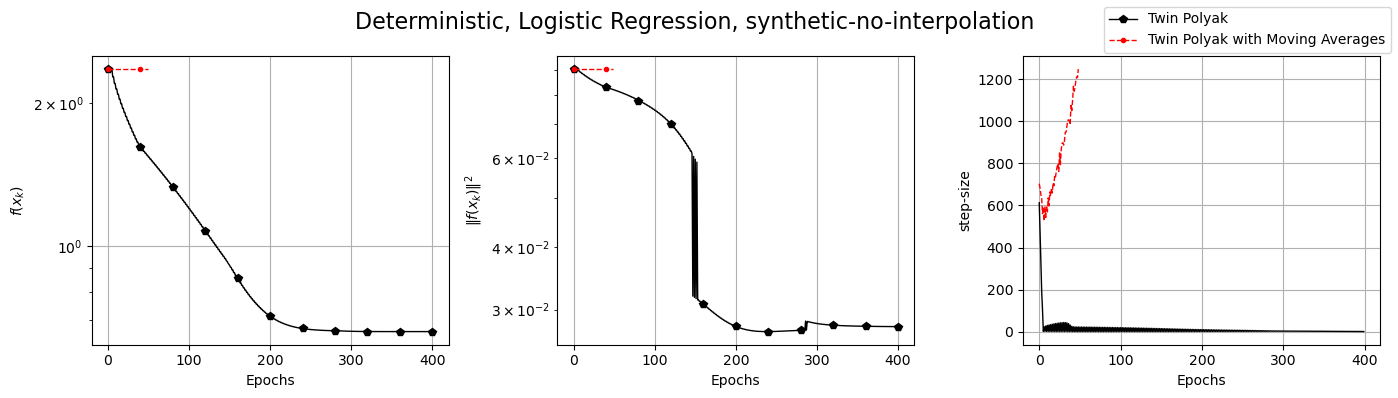

In [67]:
n_epochs = 400
seed = 0

histories = []
labels = []

# hist_sgd = train_loop(dataset=dataset, 
#                 batch_size=batch_size, 
#                 n_epochs=n_epochs, 
#                 optimizer=SGD,
#                 seed=seed, 
#                 lr=1/L,
#                 )
# histories.append(hist_sgd)
# if batch_size == train_data.shape[0]:
#         labels.append("GD 1/L")
# else:
#         labels.append("SGD 1/L")
        
# hist_sps = train_loop(dataset=dataset, 
#                 batch_size=batch_size, 
#                 n_epochs=n_epochs, 
#                 optimizer=SPS,
#                 seed=seed
#                 )
# histories.append(hist_sps)
# labels.append("SPS")

hist_twin = twin_model(dataset=dataset,
                       batch_size=batch_size,
                       n_epochs=n_epochs)
histories.append(hist_twin)
labels.append("Twin Polyak")

hist_twin = twin_model_moving_average(dataset=dataset,
                       batch_size=batch_size,
                       n_epochs=n_epochs)
histories.append(hist_twin)
labels.append("Twin Polyak with Moving Averages")

if batch_size == train_data.shape[0]:
        setting = "Deterministic"
else:
        setting = "Stochastic" 

plotter(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple"],
        linestyles=["-", "--", "-.", ":", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0],
        markers=["p", ".", "v", "v", "p"],
        f_star=0.0, 
        suptitle=f"{setting}, Logistic Regression, {dataset_name}",
        threshold=0.0)